<h1>Analyzing MNIST</h1>
<h2>Introduction</h2>
<p>In this notebook I take a look at the MNIST data set and use TensorFlow to make multiple models and visualizations on how to analyze the dataset. For those not familiar with the dataset, MNIST is a set of 70 000 hand-written digit images. 60 000 of these images will be used to train our model and 10 000 will be used to test our model.</p>

In [3]:
import matplotlib.pyplot as plt # visualization
import tensorflow as tf # model maker
import numpy as np # linear algebra
from sklearn.metrics import confusion_matrix # Determine model accuracy
from sklearn.model_selection import train_test_split

<h3>Loading the dataset in from Tensorflow/Keras</h3>
<p>In order to begin any sort of modeling it is good to bring in all of our data first and have it ready for training. We get our dataset from keras which is a higher level version of tensorflow. we then load the data into their respective variables.</p>

In [4]:
mnist = tf.keras.datasets.mnist
(x_train, y_train_cls), (x_test, y_test_cls) = mnist.load_data()
#cls is abbreviated from class since it's the original classification from 0, 1, 2, 3, 4, 5, 6, 7, 8, and 9.
#later we will convert them into vectors as the actual y_train and y_test

<p>We want more than just training and test sets just in case we might have to do some hyperparameter tuning later on so let's create 4 folds of data.</p>

In [5]:
x_val1, x_val3, y_val1_cls, y_val3_cls = train_test_split(x_train, 
                                                          y_train_cls, 
                                                          test_size=0.5, 
                                                          random_state=1)

In [6]:
x_val1, x_val2, y_val1_cls, y_val2_cls = train_test_split(x_val1, 
                                                          y_val1_cls, 
                                                          test_size=0.5, 
                                                          random_state=1)

In [7]:
x_val3, x_val4, y_val3_cls, y_val4_cls = train_test_split(x_val3,
                                                          y_val3_cls,
                                                          test_size=0.5,
                                                          random_state=1)

In [8]:
print("Length of first fold of training set: %s" % len(x_val1))
print("Length of second fold of training set: %s" % len(x_val2))
print("Length of third fold of training set: %s" % len(x_val3))
print("Length of fourth fold of training set: %s" % len(x_val4))
print("Length of test set: %s" % len(x_test))

Length of first fold of training set: 15000
Length of second fold of training set: 15000
Length of third fold of training set: 15000
Length of fourth fold of training set: 15000
Length of test set: 10000


<h3>One-Hot Encoding</h3>
<p>The goal of this section is to transform our our output into vectors that we can train our input images to predict</p>

In [9]:
y_train_cls[0:5]

array([5, 0, 4, 1, 9], dtype=uint8)

In [10]:
num_classes = 10
y_train = np.zeros((y_train_cls.shape[0], num_classes))
y_train[np.arange(len(y_train_cls)), y_train_cls] = 1

y_train[0:5,:]

array([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])

In [11]:
y_test_cls[0:5]

array([7, 2, 1, 0, 4], dtype=uint8)

In [12]:
y_test = np.zeros((y_test_cls.shape[0], num_classes))
y_test[np.arange(len(y_test_cls)), y_test_cls] = 1

y_test[0:5,:]

array([[0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]])

<p>Notice that our y_train data are all vectors with the label in the i'th position where i is the number that the corresponding image is of.

<h3>Data Dimensions</h3>

In [13]:
img_size = 28
flattened_img_size = img_size ** 2
img_shp = (img_size, img_size)

In [14]:
def plot_imgs(imgs, cls_true, cls_pred=None):
    assert len(imgs) == len(cls_true) == 9
    
    fig, axes = plt.subplots(3, 3)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)
    
    for i, ax in enumerate(axes.flat):
        ax.imshow(imgs[i].reshape(img_shp), cmap='binary')
        
        if cls_pred is None:
            xlabel = "True: {0}".format(cls_true[i])
        else:
            xlabel = "True {0}, Pred: {1}".format(cls_true[i], cls_pred[i])
        
        ax.set_xlabel(xlabel)
        
        ax.set_xticks([])
        ax.set_yticks([])
        
    plt.show()

In [15]:
y_test_cls[0]

7

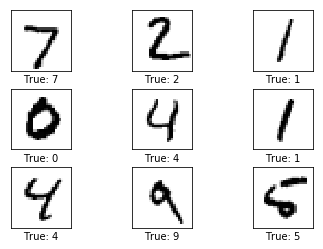

In [16]:
images = x_test[0:9]

cls_true = y_test_cls[0:9]

plot_imgs(imgs=images, cls_true=cls_true)

<h3>Model 1: Linear Classifier</h3>

In [17]:
x = tf.placeholder(tf.float32, [None, flattened_img_size]) 
#input layer takes in flattened 28 by 28 images to train

In [18]:
y_true = tf.placeholder(tf.float32, [None, num_classes]) 
#output layer (vectors that have a 1 in the i'th position based on the prediction)

In [19]:
y_true_cls = tf.placeholder(tf.int64, [None])
#Actual number being predicted [0,9]

In [20]:
weights = tf.Variable(tf.zeros([flattened_img_size, num_classes]))

In [21]:
biases = tf.Variable(tf.zeros([num_classes]))

<p>Before we build the complex convolutional neural network model we prototype a simpler linear model just for the sake of it. This linear function is gonna be built with y_hat = weights * x + biases, which is the linear form everyone is familiar with y = mx + b. The only difference is that we're going to be working in a much larger dimension.</p>

In [22]:
logits = tf.matmul(x, weights) + biases

<p>Logits is the result of the calculation that is made from the linear model and gives a estimate of how likely each image is to be each value.</p>

In [23]:
y_pred = tf.nn.softmax(logits)

<p>The softmax function then normalizes the predictions of each digit</p>

In [24]:
y_pred_cls = tf.argmax(y_pred, axis=1)

<h4>Tuning the weights and biases</h4>

<p>Cross entropy is a cost function for classifiers that measures the models performance. We then take the performance and make it a single scalar and send it forward to the optimizer in order to determine how the network wants to change its weight parameters.</p>

In [25]:
cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(logits=logits, labels=y_true)
cost = tf.reduce_mean(cross_entropy)

<h3>Optimization</h3>
<p>We use the most basic optimizer in tensorflow to train our weights</p>

In [26]:
optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.5).minimize(cost) 

<h2>Evaluating performance</h2>
<p>Determines if the prediction is the same as the ground truth value</p>

In [27]:
correct_prediction =tf.equal(y_true_cls, y_pred_cls)

<p>Turns the booelan values of which predictions were right and wrong and makes it into 0 for false and 1 for true to determine the accuracy of our predictions</p>

In [28]:
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

<h2>Training the model</h2>

In [29]:
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))
sess.run(tf.global_variables_initializer())

In [30]:
batch_size = 50

In [31]:
def optimize(num_iterations):
    for i in range(num_iterations):
        x_batch, y_true_batch, _ = mnist.load_data().random_batch(batch_size=batch_size)
        feed_dict_train = {
            x: x_batch,
            y_true: y_true_batch
        }
        sess.run(optimizer, feed_dict=feed_dict_train)

<p>Functions to help show our models perforamnce</p>

In [32]:
x_test = np.reshape(x_test, (10000, 784))

In [33]:
feed_dict_test = {
    x: x_test, # shape is (10000, 28, 28)
    y_true: y_test, # shape is (10000, 10)
    y_true_cls: y_train_cls
}


In [34]:
def print_accuracy():
    acc = sess.run(accuracy, feed_dict=feed_dict_test)
    print("Accuracy on tst-set: %f%" % acc)

In [35]:
def print_confusion_matrix():
    cls_true = y_test_cls
    cls_pred = sess.run(y_test, feed_dict=feed_dict_test)
    conmat = confusion_matrix(y_true=cls_true, y_pred=cls_pred)
    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=plt.conmat.Blues)
    plt.tight_layout()
    plt.colorbar()
    tick_marks = np.arange(num_classes)
    plt.xtickets(tick_marks, range(num_classes))
    plt.yticks(tick_marks, range(num_clases))
    plt.xlabel('Predicted')
    plt.ylabel("True")
    plt.show()

In [36]:
def plot_example_errors():
    correct, cls_pred = sess.run([correct_prediction, y_pred_cls],
                                    feed_dict=feed_dict_test)
    incorrect = (correct == False)
    images = data.x_test[incorrect]
    cls_pred = cls_pred[incorrect]
    cls_true = data.y_test_cls[incorrect]
    plot_images(images=images[0:9],
                cls_true=cls_true[0:9],
                cls_pred=cls_pred[0:9])

In [37]:
def plot_weights():
    w = sess.run(weights)

    w_min = np.min(w)
    w_max = np.max(w)

    fig, axes = plt.subplots(3, 4)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, ax in enumerate(axes.flat):

        if i<10:

            image = w[:, i].reshape(img_shape)

            ax.set_xlabel("Weights: {0}".format(i))

            ax.imshow(image, vmin=w_min, vmax=w_max, cmap='seismic')

        ax.set_xticks([])
        ax.set_yticks([])

    plt.show()

In [38]:
print_accuracy()

InvalidArgumentError: Incompatible shapes: [60000] vs. [10000]
	 [[node Equal (defined at <ipython-input-27-268738d692fc>:1)  = Equal[T=DT_INT64, _device="/job:localhost/replica:0/task:0/device:GPU:0"](_arg_Placeholder_2_0_2/_3, ArgMax)]]

Caused by op 'Equal', defined at:
  File "C:\Users\Bryan\Anaconda3\envs\MNIST\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\Bryan\Anaconda3\envs\MNIST\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\Bryan\Anaconda3\envs\MNIST\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "C:\Users\Bryan\Anaconda3\envs\MNIST\lib\site-packages\traitlets\config\application.py", line 658, in launch_instance
    app.start()
  File "C:\Users\Bryan\Anaconda3\envs\MNIST\lib\site-packages\ipykernel\kernelapp.py", line 505, in start
    self.io_loop.start()
  File "C:\Users\Bryan\Anaconda3\envs\MNIST\lib\site-packages\tornado\platform\asyncio.py", line 132, in start
    self.asyncio_loop.run_forever()
  File "C:\Users\Bryan\Anaconda3\envs\MNIST\lib\asyncio\base_events.py", line 427, in run_forever
    self._run_once()
  File "C:\Users\Bryan\Anaconda3\envs\MNIST\lib\asyncio\base_events.py", line 1440, in _run_once
    handle._run()
  File "C:\Users\Bryan\Anaconda3\envs\MNIST\lib\asyncio\events.py", line 145, in _run
    self._callback(*self._args)
  File "C:\Users\Bryan\Anaconda3\envs\MNIST\lib\site-packages\tornado\ioloop.py", line 758, in _run_callback
    ret = callback()
  File "C:\Users\Bryan\Anaconda3\envs\MNIST\lib\site-packages\tornado\stack_context.py", line 300, in null_wrapper
    return fn(*args, **kwargs)
  File "C:\Users\Bryan\Anaconda3\envs\MNIST\lib\site-packages\tornado\gen.py", line 1233, in inner
    self.run()
  File "C:\Users\Bryan\Anaconda3\envs\MNIST\lib\site-packages\tornado\gen.py", line 1147, in run
    yielded = self.gen.send(value)
  File "C:\Users\Bryan\Anaconda3\envs\MNIST\lib\site-packages\ipykernel\kernelbase.py", line 370, in dispatch_queue
    yield self.process_one()
  File "C:\Users\Bryan\Anaconda3\envs\MNIST\lib\site-packages\tornado\gen.py", line 346, in wrapper
    runner = Runner(result, future, yielded)
  File "C:\Users\Bryan\Anaconda3\envs\MNIST\lib\site-packages\tornado\gen.py", line 1080, in __init__
    self.run()
  File "C:\Users\Bryan\Anaconda3\envs\MNIST\lib\site-packages\tornado\gen.py", line 1147, in run
    yielded = self.gen.send(value)
  File "C:\Users\Bryan\Anaconda3\envs\MNIST\lib\site-packages\ipykernel\kernelbase.py", line 357, in process_one
    yield gen.maybe_future(dispatch(*args))
  File "C:\Users\Bryan\Anaconda3\envs\MNIST\lib\site-packages\tornado\gen.py", line 326, in wrapper
    yielded = next(result)
  File "C:\Users\Bryan\Anaconda3\envs\MNIST\lib\site-packages\ipykernel\kernelbase.py", line 267, in dispatch_shell
    yield gen.maybe_future(handler(stream, idents, msg))
  File "C:\Users\Bryan\Anaconda3\envs\MNIST\lib\site-packages\tornado\gen.py", line 326, in wrapper
    yielded = next(result)
  File "C:\Users\Bryan\Anaconda3\envs\MNIST\lib\site-packages\ipykernel\kernelbase.py", line 534, in execute_request
    user_expressions, allow_stdin,
  File "C:\Users\Bryan\Anaconda3\envs\MNIST\lib\site-packages\tornado\gen.py", line 326, in wrapper
    yielded = next(result)
  File "C:\Users\Bryan\Anaconda3\envs\MNIST\lib\site-packages\ipykernel\ipkernel.py", line 294, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "C:\Users\Bryan\Anaconda3\envs\MNIST\lib\site-packages\ipykernel\zmqshell.py", line 536, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "C:\Users\Bryan\Anaconda3\envs\MNIST\lib\site-packages\IPython\core\interactiveshell.py", line 2819, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "C:\Users\Bryan\Anaconda3\envs\MNIST\lib\site-packages\IPython\core\interactiveshell.py", line 2845, in _run_cell
    return runner(coro)
  File "C:\Users\Bryan\Anaconda3\envs\MNIST\lib\site-packages\IPython\core\async_helpers.py", line 67, in _pseudo_sync_runner
    coro.send(None)
  File "C:\Users\Bryan\Anaconda3\envs\MNIST\lib\site-packages\IPython\core\interactiveshell.py", line 3020, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "C:\Users\Bryan\Anaconda3\envs\MNIST\lib\site-packages\IPython\core\interactiveshell.py", line 3185, in run_ast_nodes
    if (yield from self.run_code(code, result)):
  File "C:\Users\Bryan\Anaconda3\envs\MNIST\lib\site-packages\IPython\core\interactiveshell.py", line 3267, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-27-268738d692fc>", line 1, in <module>
    correct_prediction =tf.equal(y_true_cls, y_pred_cls)
  File "C:\Users\Bryan\Anaconda3\envs\MNIST\lib\site-packages\tensorflow\python\ops\gen_math_ops.py", line 2734, in equal
    "Equal", x=x, y=y, name=name)
  File "C:\Users\Bryan\Anaconda3\envs\MNIST\lib\site-packages\tensorflow\python\framework\op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "C:\Users\Bryan\Anaconda3\envs\MNIST\lib\site-packages\tensorflow\python\util\deprecation.py", line 488, in new_func
    return func(*args, **kwargs)
  File "C:\Users\Bryan\Anaconda3\envs\MNIST\lib\site-packages\tensorflow\python\framework\ops.py", line 3274, in create_op
    op_def=op_def)
  File "C:\Users\Bryan\Anaconda3\envs\MNIST\lib\site-packages\tensorflow\python\framework\ops.py", line 1770, in __init__
    self._traceback = tf_stack.extract_stack()

InvalidArgumentError (see above for traceback): Incompatible shapes: [60000] vs. [10000]
	 [[node Equal (defined at <ipython-input-27-268738d692fc>:1)  = Equal[T=DT_INT64, _device="/job:localhost/replica:0/task:0/device:GPU:0"](_arg_Placeholder_2_0_2/_3, ArgMax)]]


<h3>Model 2: Keras Implementation of a CNN</h3>

In [55]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D
import keras

<p>Not sure why but a tutorial states that we have to reshape to 4dimensions from 3 for it to work with the keras API. We also normalize our data to make it less computationally expensive. We do this by dividing the max rgb value</p>

In [40]:
#reshape to 4 dimensional
x_train_4d = x_train.reshape(x_train.shape[0], 28, 28, 1)
x_test_4d = x_test.reshape(x_test.shape[0], 28, 28, 1)
input_shape = (28, 28, 1)
#making sure that the datatypes in the dataset are all floats so we don't round our decimals
x_train_4d = x_train_4d.astype('float32')
x_test_4d = x_test_4d.astype('float32')
#normalizing by dividing max value so values are from 0 to 1
x_train_4d /= 255
x_test_4d /= 255
print("Shape of x_train_4d: ", x_train_4d.shape)
print("Shape of x_test_4d: ", x_test_4d.shape)

Shape of x_train_4d:  (60000, 28, 28, 1)
Shape of x_test_4d:  (10000, 28, 28, 1)


In [41]:
x_train_4d[0]
#verify that values are floats, normalized, and have the correct dimensions.

array([[[0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ]],

       [[0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        

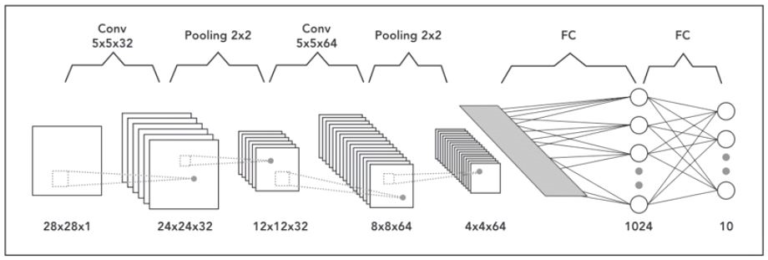

In [42]:
from IPython.display import Image
Image('https://engmrk.com/wp-content/uploads/2018/09/Image_CNN-768x260.png')

<p>The above image is the architecture that we will be using in keras to build our CNN. The layers are in the following order
    <ol>
        <li>input layer</li>
        <li>32 filters of size 5x5</li>
        <li>Max pooling layer with pool size of 2x2</li>
        <li>64 filters of size 5x5</li>
        <li>Max pooling layer with pool size of 2x2</li>
        <li>Flattening layer to convert 2D matrix to 1D vectors (allow us to fully connect in next layer)</li>
        <li>fully connected layer with 1024 neurons and relu activation functions.</li>
        <li>droupout 20% of neurons randomly to reduce overfitting</li>
        <li>lastly we will use a softmax layer to make the actual classification vector</li>
    </ol>
</p>

In [43]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(5,5), input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(64, kernel_size=(5,5), input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Flatten())
model.add(Dense(1024, activation=tf.nn.relu))
model.add(Dropout(0.2))
model.add(Dense(10,activation=tf.nn.softmax))

In [44]:
model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [45]:
model.fit(x=x_train_4d,y=y_train_cls,epochs=100)

Epoch 1/100
60000/60000 [==============================] - 12s 201us/step - loss: 0.1226 - acc: 0.9622
Epoch 2/100
60000/60000 [==============================] - 11s 181us/step - loss: 0.0539 - acc: 0.9841
Epoch 3/100
60000/60000 [==============================] - 11s 181us/step - loss: 0.0441 - acc: 0.9869
Epoch 4/100
60000/60000 [==============================] - 11s 181us/step - loss: 0.0392 - acc: 0.9886
Epoch 5/100
60000/60000 [==============================] - 11s 184us/step - loss: 0.0363 - acc: 0.9902
Epoch 6/100
60000/60000 [==============================] - 11s 184us/step - loss: 0.0323 - acc: 0.9918
Epoch 7/100
60000/60000 [==============================] - 11s 183us/step - loss: 0.0346 - acc: 0.9918
Epoch 8/100
60000/60000 [==============================] - 11s 183us/step - loss: 0.0289 - acc: 0.9928
Epoch 9/100
60000/60000 [==============================] - 11s 182us/step - loss: 0.0304 - acc: 0.9934
Epoch 10/100
60000/60000 [==============================] - 11s 183us/ste

60000/60000 [==============================] - 11s 183us/step - loss: 0.3833 - acc: 0.9762
Epoch 80/100
60000/60000 [==============================] - 11s 182us/step - loss: 0.3555 - acc: 0.9779
Epoch 81/100
60000/60000 [==============================] - 11s 182us/step - loss: 0.4407 - acc: 0.9726
Epoch 82/100
60000/60000 [==============================] - 11s 183us/step - loss: 0.5078 - acc: 0.9684
Epoch 83/100
60000/60000 [==============================] - 11s 183us/step - loss: 0.4826 - acc: 0.9699
Epoch 84/100
60000/60000 [==============================] - 11s 183us/step - loss: 0.5388 - acc: 0.9665
Epoch 85/100
60000/60000 [==============================] - 11s 185us/step - loss: 0.5134 - acc: 0.9681
Epoch 86/100
60000/60000 [==============================] - 11s 186us/step - loss: 0.7048 - acc: 0.9562
Epoch 87/100
60000/60000 [==============================] - 11s 182us/step - loss: 0.4616 - acc: 0.9713
Epoch 88/100
60000/60000 [==============================] - 11s 179us/step - 

In [51]:
x_test_4d = x_test.reshape(x_test.shape[0], 28, 28, 1)

In [52]:
test_error_rate = model.evaluate(x_test_4d, y_test_cls, verbose=0)
print("The mean squared error (MSE) for the test data set is: {}".format(test_error_rate))

The mean squared error (MSE) for the test data set is: [0.4142360282180402, 0.9743]


In [53]:
model.save("train_model_2.h5")

In [57]:
model = keras.models.load_model('train_model_2.h5')

In [58]:
#predictions = model.predict(new_data)

<p>This completes the implementation of the 2nd CNN model using the higher level keras APi</p>